# pyHS2MF6: Coupled Mode - Processing Results and Getting Output

This Jupyter Notebook provides examples of extracting and processing coupled model output. It also provides definitions of coupled mode outputs.

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon, Point
import pickle
import matplotlib.tri as tri
import datetime as dt
from copy import deepcopy

In [3]:
import flopy

### Specify the Time Interval for Examination

For the watershed and stream flow routing component of the integrated model, want to make sure that drop off about six months of simulation to provide for a "hot start".

In [4]:
CStart_DT = dt.datetime( 2013, 7, 1 )
CEnd_DT = dt.datetime( 2018, 7, 1 )

### Set Paths Models

The user of this notebook can perform the same operations on their own model by swapping out pathnames in this section.

In [5]:
# Absolute path to MODFLOW 6 and associated parameters
MF6_Dir = r'D:\Data\pyHS2MF6_Testing\CP_pyMF6'
MF6_Out_Dir = r'D:\Data\pyHS2MF6_Testing\CP_pyMF6\Outputs'
# Root name of Modflow 6 Model
MF6_Root = "DC_MF6"
OUT_ROOT = "cpTest"

In [6]:
# fixed MODFLOW serialized tracking object names
MF6_Indexes = "IndexDict.pickle"
MF6_f_HSPF = "UZF_from_HSPF.pickle"
MF6_SurfDischarge = "GSURF_from_MF6.pickle"
MF6_RejInfilt = "REJINF_from_MF6.pickle"

In [7]:
# Absolute path to HSPF and associated parameters
HSPF_Dir = r'D:\Data\pyHS2MF6_Testing\CP_mHSP2'
HSPF_HDF5 = "DC_CalibmHSP2.h5"
GAUGE_XLSX = r'D:\Data\pyHS2MF6_Testing\CP_mHSP2\DolanProcessed_Hr-Processed.xlsx'
GAUGE_SHT = "Daily"
GAUGE_HDR = "Discharge_cfs"
HSPF_Out_Dir = r'D:\Data\pyHS2MF6_Testing\CP_mHSP2\Outputs'

### Set Paths to Helper SHP Files for Visualization

A variety of pre-made shapefiles are used to assist in visualization of model results.

In [8]:
SHP_GRID = r'D:\Data\pyHS2MF6_Testing\JNotes\Shpfiles\MF6_2D_ModelGrid.shp'
SHP_UZFGRID = r'D:\Data\pyHS2MF6_Testing\JNotes\Shpfiles\cpMGridUzfNo.shp'
SHP_MSURF = r'D:\Data\pyHS2MF6_Testing\JNotes\Shpfiles\ModelSurfEl.shp'

In [9]:
gpd_MGrid = gpd.read_file( SHP_GRID )
gpd_UzfGrid = gpd.read_file( SHP_UZFGRID )
gpd_MSurf = gpd.read_file( SHP_MSURF )
ProjCRS = gpd_MGrid.crs

### Conversion and Helper Lambdas

In [10]:
ConvAFDtoCFS = lambda AFD: ( AFD * ( 43560.0 / 1.0**2 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 
ConvAFtoCM = lambda AF: AF * 1233.48185532
ConvCMDtoCFS = lambda CMD: ( CMD * ( 35.3147 / 1.0**3 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 

## HSPF Model Results

The inputs and outputs from the HSPF-portion of the coupled model are archived/maintained in one HDF5 repository. 

In [11]:
InStore = os.path.normpath( os.path.join( HSPF_Dir, HSPF_HDF5 ) )
with pd.HDFStore( InStore ) as store:
    cp_Tot = store.get(key=r'/RESULTS/COUPLED/')
    cp_PL1 = store.get(key=r'/RESULTS/PERLND_P001/COUPLED/')
    cp_PL2 = store.get(key=r'/RESULTS/PERLND_P002/COUPLED/')
    cp_PL3 = store.get(key=r'/RESULTS/PERLND_P003/COUPLED/')
    cp_PL4 = store.get(key=r'/RESULTS/PERLND_P004/COUPLED/')
    cp_PL5 = store.get(key=r'/RESULTS/PERLND_P005/COUPLED/')
    cp_PL6 = store.get(key=r'/RESULTS/PERLND_P006/COUPLED/')
    cp_PL7 = store.get(key=r'/RESULTS/PERLND_P007/COUPLED/')
    cp_PL8 = store.get(key=r'/RESULTS/PERLND_P008/COUPLED/')
    cp_PL9 = store.get(key=r'/RESULTS/PERLND_P009/COUPLED/')
    cp_PL10 = store.get(key=r'/RESULTS/PERLND_P010/COUPLED/')
    cp_PL11 = store.get(key=r'/RESULTS/PERLND_P011/COUPLED/')
    cp_PL12 = store.get(key=r'/RESULTS/PERLND_P012/COUPLED/')
    H_RR5 = store.get(key=r'/RESULTS/RCHRES_R005/HYDR/')
    cp_RR1 = store.get(key=r'/RESULTS/RCHRES_R001/COUPLED/')
    cp_RR2 = store.get(key=r'/RESULTS/RCHRES_R002/COUPLED/')
    cp_RR3 = store.get(key=r'/RESULTS/RCHRES_R003/COUPLED/')
    cp_RR4 = store.get(key=r'/RESULTS/RCHRES_R004/COUPLED/')
    cp_RR5 = store.get(key=r'/RESULTS/RCHRES_R005/COUPLED/')
# end with and close of store

### Overal Coupled Flow Summary

The whole model or overall coupled flow summary available from the HSPF-side is stored at the following path.

- */RESULTS/COUPLED/*

This DataFrame has the following columns or fields.

0. **Tot_from_Mf6_toWS** (GWITOTAL): Total inflow from MODFLOW discharge to ground surface in af/day; includes spring (DRN) discharge within the HSPF model domain, UZF groundwater seepage discharge, and UZF rejected infiltration
1. **Tot_from_Mf6_toOutSide** (GWIUATOTAL): Total inflow from MODFLOW discharge to ground surface that is outside of the HSPF model domain in af/day; this is spring discharge for springs located outside of the model domain.
2. **Tot_to_Mf6** (GWOTOTAL): Total outflow from HSPF to MODFLOW 6 UZF in af/day; includes deep infiltration to inactive groundwater from PERLND areas and RCHRES discharge to the specified groundwater exit

In [12]:
OurIndexer = cp_Tot.index.to_pydatetime()
OurIndexer = pd.DatetimeIndex(data=OurIndexer, freq='infer' )

In [13]:
cp_Tot = cp_Tot.reindex( OurIndexer )

In [14]:
cpTotHdrs = [ "Tot_from_Mf6_toWS", "Tot_from_Mf6_toOutSide", "Tot_to_Mf6" ]

In [15]:
display( HTML( cp_Tot.describe().to_html() ) )

,Tot_from_Mf6_toWS,Tot_from_Mf6_toOutSide,Tot_to_Mf6
count,2070.000000,2070.000000,2070.000000
mean,87.730873,15.207236,25.018614
std,9.736317,22.508570,2.674568
min,0.000000,0.000000,1.196222
25%,80.846205,8.598331,23.648704
50%,85.110439,9.372501,25.390034
75%,91.861332,11.617692,26.630694
max,150.447403,268.087738,35.457966


In [16]:
cpTotHdrs.append( "Tot_UZFDis_m3d" ) #3
cpTotHdrs.append( "Tot_HtoUZF_m3d" ) #4
cpTotHdrs.append( "Tot_Outside_m3d" ) #5

In [17]:
cp_Tot[cpTotHdrs[3]] = cp_Tot.apply( lambda row: ConvAFtoCM( row[cpTotHdrs[0] ] ), axis=1 )
cp_Tot[cpTotHdrs[4]] = cp_Tot.apply( lambda row: ConvAFtoCM( row[cpTotHdrs[2] ] ), axis=1 )
cp_Tot[cpTotHdrs[5]] = cp_Tot.apply( lambda row: ConvAFtoCM( row[cpTotHdrs[1] ] ), axis=1 )

In [18]:
TotOut_Path = os.path.join(HSPF_Out_Dir, "%s-HSPF_Coupled.xlsx" % OUT_ROOT )
cp_Tot.to_excel(TotOut_Path, sheet_name="HSPF", columns=cpTotHdrs)

In [19]:
cp_Tot = cp_Tot.loc[CStart_DT:CEnd_DT].copy()

### PERLND Coupled Summary

Pervious land summary of coupled flows is provided within the results for each PERLND target Id (TargId). This would be something similar to the following path within the HDF5 file.

- */RESULTS/PERLND_P001/COUPLED/*

Each coupled PERLND DataFrame (by TargID) has the following columns or fields.

0. **Mf6_Total** (GWITOTPL): Total inflow from MODFLOW discharge in af/day by pervious HRU; typically this included rejected infiltration and UZF groundwater discharge as spring discharge is typically allocated to a stream reach.
1. **Mf6_LZS** (GWILZONE): MODFLOW discharge assigned to the lower soil zone in inches - requires the area for each HRU for further processing
2. **Mf6_UZS** (GWIUZONE): MODFLOW discharge assigned to the upper soil zone in inches - requires the area for each HRU for further processing
3. **Mf6_RO** (GWIOVOL): MODFLOW discharge that becomes runoff and goes directly to a RCHRES in acre-ft. Includes spring discharge when DRN discharge is assigned to an HRU rather than a reach
4. **IGWO_Mf6** (IGWOVOL): Volume of water sent to MODFLOW 6 as inflow to inactive groundwater for each PERLND in af/day

In [20]:
cpPLHdrs = [ "Mf6_Total", "Mf6_LZS", "Mf6_UZS", "Mf6_RO", "IGWO_Mf6" ]

In [21]:
cp_PL1 = cp_PL1.reindex( OurIndexer )
cp_PL2 = cp_PL2.reindex( OurIndexer )
cp_PL3 = cp_PL3.reindex( OurIndexer )
cp_PL4 = cp_PL4.reindex( OurIndexer )
cp_PL5 = cp_PL5.reindex( OurIndexer )
cp_PL6 = cp_PL6.reindex( OurIndexer )
cp_PL7 = cp_PL7.reindex( OurIndexer )
cp_PL8 = cp_PL8.reindex( OurIndexer )
cp_PL9 = cp_PL9.reindex( OurIndexer )
cp_PL10 = cp_PL10.reindex( OurIndexer )
cp_PL11 = cp_PL11.reindex( OurIndexer )
cp_PL12 = cp_PL12.reindex( OurIndexer )

In [22]:
cp_PL1 = cp_PL1.loc[CStart_DT:CEnd_DT].copy()
cp_PL2 = cp_PL2.loc[CStart_DT:CEnd_DT].copy()
cp_PL3 = cp_PL3.loc[CStart_DT:CEnd_DT].copy()
cp_PL4 = cp_PL4.loc[CStart_DT:CEnd_DT].copy()
cp_PL5 = cp_PL5.loc[CStart_DT:CEnd_DT].copy()
cp_PL6 = cp_PL6.loc[CStart_DT:CEnd_DT].copy()
cp_PL7 = cp_PL7.loc[CStart_DT:CEnd_DT].copy()
cp_PL8 = cp_PL8.loc[CStart_DT:CEnd_DT].copy()
cp_PL9 = cp_PL9.loc[CStart_DT:CEnd_DT].copy()
cp_PL10 = cp_PL10.loc[CStart_DT:CEnd_DT].copy()
cp_PL11 = cp_PL11.loc[CStart_DT:CEnd_DT].copy()
cp_PL12 = cp_PL12.loc[CStart_DT:CEnd_DT].copy()

In [23]:
display( HTML( cp_PL1.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.0,1827.0,1827.0,1827.0,1827.000000
mean,0.0,0.0,0.0,0.0,0.013122
std,0.0,0.0,0.0,0.0,0.100895
min,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.000000
max,0.0,0.0,0.0,0.0,2.125903


In [24]:
display( HTML( cp_PL2.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1.827000e+03,1827.0,1827.0,1827.000000
mean,0.000025,2.878901e-08,0.0,0.0,0.015311
std,0.000189,2.137027e-07,0.0,0.0,0.116161
min,0.000000,0.000000e+00,0.0,0.0,0.000000
25%,0.000000,0.000000e+00,0.0,0.0,0.000000
50%,0.000000,0.000000e+00,0.0,0.0,0.000000
75%,0.000000,0.000000e+00,0.0,0.0,0.000000
max,0.003755,4.255235e-06,0.0,0.0,2.479415


In [25]:
display( HTML( cp_PL3.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,4.604722,0.006840,0.0,0.0,0.013704
std,0.266280,0.000396,0.0,0.0,0.096771
min,4.214477,0.006260,0.0,0.0,0.000000
25%,4.412837,0.006555,0.0,0.0,0.000000
50%,4.520085,0.006714,0.0,0.0,0.000000
75%,4.683142,0.006956,0.0,0.0,0.000000
max,5.388390,0.008004,0.0,0.0,1.846254


In [26]:
display( HTML( cp_PL4.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.0,1827.0,1827.0,1827.0,1827.000000
mean,0.0,0.0,0.0,0.0,0.003824
std,0.0,0.0,0.0,0.0,0.024165
min,0.0,0.0,0.0,0.0,0.000000
25%,0.0,0.0,0.0,0.0,0.000000
50%,0.0,0.0,0.0,0.0,0.000000
75%,0.0,0.0,0.0,0.0,0.000000
max,0.0,0.0,0.0,0.0,0.496191


In [27]:
display( HTML( cp_PL5.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,1.549175,0.001288,0.0,0.0,0.003076
std,0.306617,0.000255,0.0,0.0,0.016575
min,1.151095,0.000957,0.0,0.0,0.000000
25%,1.294647,0.001076,0.0,0.0,0.000000
50%,1.476993,0.001228,0.0,0.0,0.000000
75%,1.751395,0.001456,0.0,0.0,0.000000
max,2.331704,0.001938,0.0,0.0,0.247128


In [28]:
display( HTML( cp_PL6.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,0.140573,0.000314,0.0,0.0,0.003470
std,0.054671,0.000122,0.0,0.0,0.020611
min,0.073456,0.000164,0.0,0.0,0.000000
25%,0.097030,0.000217,0.0,0.0,0.000000
50%,0.125851,0.000282,0.0,0.0,0.000000
75%,0.172755,0.000386,0.0,0.0,0.000000
max,0.293557,0.000657,0.0,0.0,0.352531


In [29]:
display( HTML( cp_PL7.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,5.722973,0.003784,0.0,0.0,0.000342
std,0.660548,0.000437,0.0,0.0,0.003862
min,4.784928,0.003163,0.0,0.0,0.000000
25%,5.156551,0.003409,0.0,0.0,0.000000
50%,5.613877,0.003711,0.0,0.0,0.000000
75%,6.214417,0.004108,0.0,0.0,0.000000
max,7.260612,0.004800,0.0,0.0,0.136614


In [30]:
display( HTML( cp_PL8.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,0.040634,0.000093,0.0,0.0,0.015755
std,0.008556,0.000019,0.0,0.0,0.111162
min,0.031841,0.000073,0.0,0.0,0.000000
25%,0.034435,0.000078,0.0,0.0,0.000000
50%,0.038151,0.000087,0.0,0.0,0.000000
75%,0.044308,0.000101,0.0,0.0,0.000000
max,0.127192,0.000290,0.0,0.0,2.032545


In [31]:
display( HTML( cp_PL9.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,0.259565,0.000378,0.0,0.0,0.004084
std,0.089501,0.000130,0.0,0.0,0.025575
min,0.000000,0.000000,0.0,0.0,0.000000
25%,0.208347,0.000303,0.0,0.0,0.000000
50%,0.271817,0.000395,0.0,0.0,0.000000
75%,0.334150,0.000486,0.0,0.0,0.000000
max,0.365534,0.000532,0.0,0.0,0.524889


In [32]:
display( HTML( cp_PL10.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1.827000e+03,1.827000e+03,1827.0,1827.0,1827.000000
mean,2.169271e-09,1.057262e-11,0.0,0.0,0.004064
std,4.597845e-08,2.240910e-10,0.0,0.0,0.024704
min,0.000000e+00,0.000000e+00,0.0,0.0,0.000000
25%,0.000000e+00,0.000000e+00,0.0,0.0,0.000000
50%,0.000000e+00,0.000000e+00,0.0,0.0,0.000000
75%,0.000000e+00,0.000000e+00,0.0,0.0,0.000000
max,1.611960e-06,7.856412e-09,0.0,0.0,0.526750


In [33]:
display( HTML( cp_PL11.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1.827000e+03,1827.0,1827.0,1827.000000
mean,0.000019,6.518999e-08,0.0,0.0,0.003861
std,0.000113,3.797186e-07,0.0,0.0,0.022512
min,0.000000,0.000000e+00,0.0,0.0,0.000000
25%,0.000000,0.000000e+00,0.0,0.0,0.000000
50%,0.000000,0.000000e+00,0.0,0.0,0.000000
75%,0.000000,0.000000e+00,0.0,0.0,0.000000
max,0.002138,7.208705e-06,0.0,0.0,0.428163


In [34]:
display( HTML( cp_PL12.describe().to_html() ) )

,Mf6_Total,Mf6_LZS,Mf6_UZS,Mf6_RO,IGWO_Mf6
count,1827.000000,1827.000000,1827.0,1827.0,1827.000000
mean,0.262317,0.000742,0.0,0.0,0.004148
std,0.079967,0.000226,0.0,0.0,0.024001
min,0.159136,0.000450,0.0,0.0,0.000000
25%,0.184682,0.000522,0.0,0.0,0.000000
50%,0.248960,0.000704,0.0,0.0,0.000000
75%,0.341306,0.000965,0.0,0.0,0.000000
max,0.400357,0.001132,0.0,0.0,0.471850


### RCHRES Coupled Summary

Stream segment (RCHRES) summary of coupled flows is provided within the results for each RCHRES target Id (TargId). This would be something similar to the following path within the HDF5 file.

- */RESULTS/RCHRES_R001/COUPLED/* 

Each coupled RCHRES DataFrame (by TargID) has the following columns or fields.

0. **Mf6_Total** (GWITOTRR): Total inflow from MODFLOW discharge in af/day by RCHRES. Does not include runoff from MODFLOW discharge to pervious lands, see PERLND **Mf6_RO** for this quantity.
1. **Mf6_VOL** (GWIVOL): Volume of water coming into each RCHRES directly from MODFLOW 6 in af/day
2. **OVOL_Mf6** (GWOVOL): Volume of water sent to MODFLOW 6 as losses to groundwater for each RCHRES in af/day; these are the outflows from the specified to groundwater exit.

In [35]:
cpRRHdrs = [ "Mf6_Total", "Mf6_VOL", "OVOL_Mf6" ]

In [36]:
cp_RR1 = cp_RR1.reindex( OurIndexer )
cp_RR2 = cp_RR2.reindex( OurIndexer )
cp_RR3 = cp_RR3.reindex( OurIndexer )
cp_RR4 = cp_RR4.reindex( OurIndexer )
cp_RR5 = cp_RR5.reindex( OurIndexer )

In [37]:
cp_RR1 = cp_RR1.loc[CStart_DT:CEnd_DT].copy()
cp_RR2 = cp_RR2.loc[CStart_DT:CEnd_DT].copy()
cp_RR3 = cp_RR3.loc[CStart_DT:CEnd_DT].copy()
cp_RR4 = cp_RR4.loc[CStart_DT:CEnd_DT].copy()
cp_RR5 = cp_RR5.loc[CStart_DT:CEnd_DT].copy()

In [38]:
display( HTML( cp_RR1.describe().to_html() ) )

,Mf6_Total,Mf6_VOL,OVOL_Mf6
count,1827.000000,1827.000000,1827.000000
mean,8.351577,8.351577,4.386179
std,1.544683,1.544683,0.768685
min,6.165954,6.165954,2.779397
25%,7.271993,7.271993,3.969439
50%,7.829999,7.829999,4.254569
75%,8.742273,8.742273,4.572595
max,13.026773,13.026773,6.675582


In [39]:
display( HTML( cp_RR2.describe().to_html() ) )

,Mf6_Total,Mf6_VOL,OVOL_Mf6
count,1827.000000,1827.000000,1827.000000
mean,2.509472,2.509472,5.398243
std,1.297539,1.297539,1.571183
min,0.682198,0.682198,2.234651
25%,1.445306,1.445306,4.294966
50%,2.224071,2.224071,5.392801
75%,3.166178,3.166178,6.924679
max,5.378039,5.378039,7.692066


In [40]:
display( HTML( cp_RR3.describe().to_html() ) )

,Mf6_Total,Mf6_VOL,OVOL_Mf6
count,1827.000000,1827.000000,1827.000000
mean,25.819735,25.819735,7.692065
std,1.260690,1.260690,0.000000
min,24.185038,24.185038,7.692066
25%,24.753559,24.753559,7.692066
50%,25.583628,25.583628,7.692066
75%,26.669123,26.669123,7.692066
max,28.961206,28.961206,7.692066


In [41]:
display( HTML( cp_RR4.describe().to_html() ) )

,Mf6_Total,Mf6_VOL,OVOL_Mf6
count,1827.000000,1827.000000,1827.000000
mean,11.697549,11.697549,7.692065
std,0.519542,0.519542,0.000000
min,10.869193,10.869193,7.692066
25%,11.225250,11.225250,7.692066
50%,11.665050,11.665050,7.692066
75%,12.199259,12.199259,7.692066
max,12.476482,12.476482,7.692066


In [42]:
display( HTML( cp_RR5.describe().to_html() ) )

,Mf6_Total,Mf6_VOL,OVOL_Mf6
count,1827.000000,1827.000000,1827.0
mean,25.053871,0.090201,0.0
std,0.249332,0.050454,0.0
min,24.663427,0.045637,0.0
25%,24.837583,0.054881,0.0
50%,25.029957,0.068468,0.0
75%,25.257197,0.108110,0.0
max,25.570547,0.262134,0.0


### Dolan Creek Gauge Comparison

In [43]:
H_RR5 = H_RR5.reindex( OurIndexer )

In [44]:
H_RR5["ovol_cfs"] = H_RR5.apply( lambda row: ConvAFDtoCFS( row["OVOL1"] ), axis=1 )

In [45]:
H_RR5 = H_RR5.loc[CStart_DT:CEnd_DT].copy()

In [46]:
display( HTML( H_RR5.describe().to_html() ) )

,DEP,IVOL,O1,OVOL1,PRSUPY,RO,ROVOL,SAREA,VOL,VOLEV,ovol_cfs
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,2.585865,32.583889,16.288712,32.308189,0.188448,16.288712,32.308189,33.568687,265.864960,0.473299,16.288712
std,0.202721,44.137058,21.820618,43.280563,0.722424,21.820618,43.280563,0.212440,6.751856,0.162852,21.820617
min,2.093316,16.924715,8.281853,16.426815,0.000000,8.281853,16.426815,33.033325,249.649597,0.109659,8.281853
25%,2.478748,23.617015,11.758648,23.322939,0.000000,11.758648,23.322939,33.456205,262.304764,0.316025,11.758648
50%,2.571665,26.220121,13.095397,25.974340,0.000000,13.095397,25.974340,33.555977,265.372711,0.519907,13.095397
75%,2.664240,31.003018,15.530196,30.803694,0.000089,15.530196,30.803694,33.653704,268.442657,0.618279,15.530196
max,4.128910,1161.225098,565.838135,1122.323608,9.187819,565.838135,1122.323608,35.142803,318.179749,0.769552,565.838153


Load the gauge data for comparison

In [47]:
GAUGE_XLSX = r'D:\Data\pyHS2MF6_Testing\testCP_mHSP2\DolanProcessed_Hr-Processed.xlsx'
GAUGE_SHT = "Daily"
GAUGE_HDR = "Discharge_cfs"

In [48]:
DCGauge = pd.read_excel( GAUGE_XLSX, sheet_name=GAUGE_SHT, header=0, index_col=0, parse_dates=True )

In [49]:
DCGauge = DCGauge[[GAUGE_HDR]].loc[CStart_DT:CEnd_DT].copy()

In [50]:
display( HTML( DCGauge.describe().to_html() ) )

,Discharge_cfs
count,1827.000000
mean,14.924813
std,4.637589
min,8.030938
25%,11.859896
50%,13.535417
75%,16.627604
max,44.078827


In [51]:
disTicks = [ 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0 ]

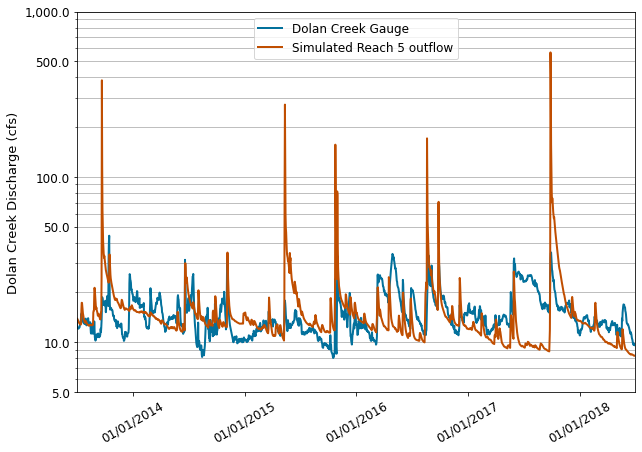

In [52]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Dcg, = ax11.plot( DCGauge.index, DCGauge[GAUGE_HDR], color='xkcd:ocean blue', linewidth=2,
                  label="Dolan Creek Gauge" )
Rc5, = ax11.plot( H_RR5.index, H_RR5["ovol_cfs"], color='xkcd:burnt orange', linewidth=2,
                  label="Simulated Reach 5 outflow" )
ax11.legend( (Dcg, Rc5 ), 
             ("Dolan Creek Gauge", "Simulated Reach 5 outflow" ),
             loc='upper center', fontsize=12)
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 1000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Dolan Creek Discharge (cfs)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )

## MODFLOW 6 model

Load the MODFLOW 6 portion of the coupled model results. The MODFLOW 6 results are all in the standard MODFLOW output files and the user needs to take care of specify which observations that they want recorded. Here we have specified observations for the UZF package by HRU and for rejected infiltration, discharge to ground surface and recharge.

Heads and depth to water can also be plotted/output if desired.

### Load the MODFLOW 6 Model

This provides access to a variety of parameters and specifications that will be helpful for processing the output

In [53]:
mf6_sim = flopy.mf6.MFSimulation.load( MF6_Root, 'mf6', 'mf6', MF6_Dir )

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package uzf...
    loading package ic...
    loading package gnc...
    loading package sto...
    loading package npf...
    loading package ghb...
    loading package chd...
    loading package drn...
    loading package oc...
    loading package riv...
    loading package rch...
  loading ims package dc_mf6...


In [54]:
tdis = mf6_sim.get_package('tdis')

In [55]:
StartDT = dt.datetime.strptime( tdis.start_date_time.get_data(), "%Y-%m-%d" )
StartDT

datetime.datetime(2013, 1, 1, 0, 0)

In [56]:
mf6 = mf6_sim.get_model( MF6_Root.lower() )

In [57]:
disv = mf6.get_package( 'disv' )

In [58]:
NCPL = disv.ncpl.get_data()
NCPL

12347

In [59]:
NLAY = disv.nlay.get_data()
NLAY

7

Make a 2D, plan-view collection of points to represent the 2D model mesh

In [60]:
X0 = disv.xorigin.get_data()
Y0 = disv.yorigin.get_data()
X0, Y0

(303000.0, 3306000.0)

In [61]:
XCentList = mf6.modelgrid.xcellcenters
len(XCentList)

12347

In [62]:
YCentList = mf6.modelgrid.ycellcenters
len(YCentList)

12347

In [63]:
XCoord = np.array( XCentList, dtype=np.float32 ) + X0
YCoord = np.array( YCentList, dtype=np.float32 ) + Y0

In [64]:
PointList2D = list()
for iI in range(NCPL):
    PointList2D.append( Point(XCoord[iI], YCoord[iI]) )
# end for

### Load the Serialized Tracking Information

Tracking of the communication and flows sent between MODFLOW 6 and HSPF is archived to four pickle files. These pickle files are written to the MODFLOW 6 directory at the end of the simulation.

The four serialized tracking information objects are:

1. A dictionary, **IndexDict**, stored in 'IndexDict.pickle' (**MF6_Indexes**), that contains the following items by key: value
    - ncpl : number of model cells in a layer
    - nuzf : number of uzf boundary cells == NUZFCELLS
    - sim_day_index : Pandas datetime index for the simulation with daily frequency
    - sim_month_index : Pandas datatime index for the simulation with monthly frequency
2. A numpy rec.array **TRACK_UZF_IN**, stored in 'UZF_from_HSPF.pickle' (**MF6_f_HSPF**), that has the total monthly flow for each UZF cell that is setn from HSPF to MODFLOW 6. This includes RCHRES discharge to groundwater through the specified exit and includes deep infiltration to inactive groundwater
3. A numpy rec.array **TRACK_DIS_OUT**, stored in 'GSURF_from_MF6.pickle' (**MF6_SurfDischarge**), that has the total monthly flow sent from each plan view cell ID location (i.e. 2D cell ID) to HSPF and represents groundwater discharge to the ground surface. This includes DRN discharge and UZF groundwater seepage discharge
4. A numpy rec.array **TRACK_REJI_OUT**, stored in 'REJINF_from_MF6.pickle' (**MF6_RejInfilt**), that has the total monthly flow sent from each plan view cell ID location (i.e. 2D cell ID) to HSPF and represents rejected infiltration
    - If water is coming from HSPF in the same locations as infiltration is being rejected then have a parameterization issue

In [65]:
MF6_Indexes = "IndexDict.pickle"
MF6_f_HSPF = "UZF_from_HSPF.pickle"
MF6_SurfDischarge = "GSURF_from_MF6.pickle"
MF6_RejInfilt = "REJINF_from_MF6.pickle"

In [66]:
InFiler = os.path.normpath( os.path.join( MF6_Dir, MF6_Indexes ) )
with open( InFiler, 'rb' ) as IP:
    IndexDict = pickle.load( IP )
# end with
InFiler = os.path.normpath( os.path.join( MF6_Dir, MF6_f_HSPF) )
with open( InFiler, 'rb' ) as IP:
    TRACK_UZF_IN = pickle.load( IP )
# end with
InFiler = os.path.normpath( os.path.join( MF6_Dir, MF6_SurfDischarge) )
with open( InFiler, 'rb' ) as IP:
    TRACK_DIS_OUT = pickle.load( IP )
# end with
InFiler = os.path.normpath( os.path.join( MF6_Dir, MF6_RejInfilt ) )
with open( InFiler, 'rb' ) as IP:
    TRACK_REJI_OUT = pickle.load( IP )
# end with

In [67]:
MFDTIndex = IndexDict['sim_day_index' ]
MFMonIndex = IndexDict['sim_month_index' ]

In [68]:
CurIndexList = MFDTIndex.to_pydatetime()
MFDTIndex = pd.DatetimeIndex( data=CurIndexList, freq='infer' )

In [69]:
CurIndexList = MFMonIndex.to_pydatetime()
MFMonIndex = pd.DatetimeIndex( data=CurIndexList, freq='infer' )

### Overall Budget

In [70]:
mfl = flopy.utils.mflistfile.Mf6ListBudget( os.path.join( MF6_Dir, "%s.lst" % MF6_Root ) )

In [71]:
budgRA = mfl.get_cumulative()

In [72]:
incDF, cumDF = mfl.get_dataframes( start_datetime=StartDT.strftime("%m-%d-%Y") )

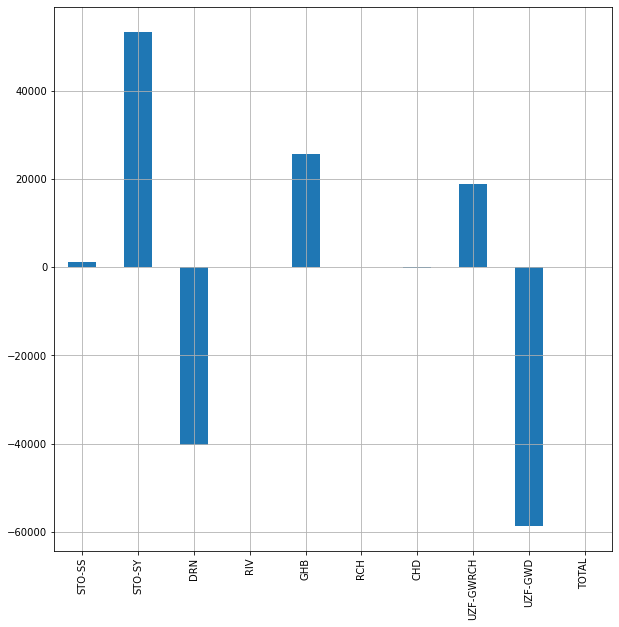

In [73]:
groups = incDF.groupby(lambda x:x.split('_')[-1],axis=1).groups
df_flux_in = incDF.loc[:,groups["IN"]]
df_flux_in.columns = df_flux_in.columns.map(lambda x:x.split('_')[0])

df_flux_out = incDF.loc[:,groups["OUT"]]
df_flux_out.columns = df_flux_out.columns.map(lambda x:x.split('_')[0])


df_flux_delta = df_flux_in - df_flux_out
df_flux_delta.iloc[-1,:].plot(kind="bar",figsize=(10,10),grid=True);

In [74]:
OutFiler = os.path.normpath( os.path.join( MF6_Out_Dir, "%s-Budgets.xlsx" % OUT_ROOT ) )
with pd.ExcelWriter( OutFiler ) as writer:
    df_flux_in.to_excel( writer, sheet_name="In", index_label="Date" )
    df_flux_out.to_excel( writer, sheet_name="Out", index_label="Date" )
    df_flux_delta.to_excel( writer, sheet_name="Delta", index_label="Date" )

### Boundary Condition Budgets

Modflow 6 stores specified observations in the .bsv file format. In this section, we read in .bsv files that contain boundary condition budget information. The user has to specify these observations before running the model so that the .bsv files will be created.

#### UZF

In [75]:
# Identify UZF Observations Path
UZFO_Path = os.path.join(MF6_Dir, 'uzf_obs.bsv')

In [76]:
# Load as DataFrame
UZFObs_DF = pd.read_csv(UZFO_Path)

In [77]:
chdrs = list( UZFObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( UZFObs_DF[tHdr], dtype=np.float64 )
# end for
UZF_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [78]:
rchHdrs = [ x for x in chdrs if 'RECHARGE' in x ]
disHdrs = [ x for x in chdrs if 'DISCHARGE' in x ]
infilHdrs = [ x for x in chdrs if ( ('INFILT' in x ) and not('NETINFILT' in x) and not('REJINFILT' in x)) ]
rejiHdrs = [ x for x in chdrs if 'REJINFILT' in x ]
netHdrs = [ x for x in chdrs if 'NETINFILT' in x ]

In [79]:
UZF_DF["Tot_Recharge"] = UZF_DF[rchHdrs].sum(axis=1)
UZF_DF["Tot_Discharge"] = UZF_DF[disHdrs].sum(axis=1)
UZF_DF["Tot_Infilt"] = UZF_DF[infilHdrs].sum(axis=1)
UZF_DF["Tot_RejInfilt"] = UZF_DF[rejiHdrs].sum(axis=1)
UZF_DF["Tot_NetInfilt"] = UZF_DF[netHdrs].sum(axis=1)

In [80]:
display( HTML( UZF_DF.describe().to_html() ) )

,time,RECHARGE,RECHARGE.1,RECHARGE.2,RECHARGE.3,RECHARGE.4,RECHARGE.5,RECHARGE.6,RECHARGE.7,RECHARGE.8,RECHARGE.9,RECHARGE.10,RECHARGE.11,DISCHARGE,DISCHARGE.1,DISCHARGE.2,DISCHARGE.3,DISCHARGE.4,DISCHARGE.5,DISCHARGE.6,DISCHARGE.7,DISCHARGE.8,DISCHARGE.9,DISCHARGE.10,DISCHARGE.11,INFILT,INFILT.1,INFILT.2,INFILT.3,INFILT.4,INFILT.5,INFILT.6,INFILT.7,INFILT.8,INFILT.9,INFILT.10,INFILT.11,REJINFILT,REJINFILT.1,REJINFILT.2,REJINFILT.3,REJINFILT.4,REJINFILT.5,REJINFILT.6,REJINFILT.7,REJINFILT.8,REJINFILT.9,REJINFILT.10,REJINFILT.11,NETINFILT,NETINFILT.1,NETINFILT.2,NETINFILT.3,NETINFILT.4,NETINFILT.5,NETINFILT.6,NETINFILT.7,NETINFILT.8,NETINFILT.9,NETINFILT.10,NETINFILT.11,Tot_Recharge,Tot_Discharge,Tot_Infilt,Tot_RejInfilt,Tot_NetInfilt
count,2069.000000,2.069000e+03,2.069000e+03,2.069000e+03,2.069000e+03,2.069000e+03,2.069000e+03,2.069000e+03,2069.000000,2.069000e+03,2069.000000,2.069000e+03,2069.000000,2069.0,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.0,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2.069000e+03,2069.000000,2069.000000,2069.000000,2069.000000
mean,1035.000000,2.295152e+04,4.503000e+03,6.263347e+03,6.082952e+03,4.577923e+03,5.847650e+03,9.033507e+03,1159.071475,9.779124e+03,3301.859836,4.990694e+03,3661.020348,0.0,-7630.056549,-7227.025906,-1417.355573,-2473.760899,-2640.585877,-16669.310778,-168.149770,-20110.120831,-6233.361189,-4264.520348,-2597.341373,85.145627,2510.432402,2289.073707,1550.659326,351.326571,3304.916549,1681.722595,16.952509,6793.101508,4413.598797,4235.910198,3629.260845,0.0,-414.397222,-134.648904,-88.336464,-47.413032,-102.093199,-585.841740,-0.775021,-1066.149500,-1574.813813,-741.272661,-1258.632448,435.675725,2096.035268,2154.426414,1462.323777,303.913470,3202.823905,1095.871329,16.177500,5726.951005,2838.754065,3494.623780,2370.609304,8.215167e+04,-71431.589093,30862.100634,-6014.374006,25198.185540
std,597.413174,2.537953e+05,3.501107e+04,5.691259e+04,5.714949e+04,5.854665e+04,4.243981e+04,9.428404e+04,12009.051649,6.036118e+04,10096.191233,2.734926e+04,20162.949328,0.0,2368.703822,846.325037,442.094686,732.082446,1493.785761,2590.389381,118.474823,1970.916659,302.108649,757.580633,409.514938,119.130687,545.623422,496.088634,424.634859,75.418597,1015.645824,74.898866,123.935955,693.104622,349.896067,222.165906,287.644431,0.0,134.803110,55.034450,20.019859,11.051775,43.918692,26.507681,5.663489,54.429449,154.402831,45.988733,149.652005,3771.228229,422.371082,447.183603,405.904935,64.999059,977.791616,48.462847,118.273086,666.527248,254.891081,181.199565,231.338341,7.167638e+05,11344.040074,3296.104904,581.507020,3560.068471
min,1.000000,6.049900e+01,1.342700e+03,1.365200e+03,6.501500e+02,1.922500e+02,1.240600e+03,9.662900e+02,0.771220,4.573200e+03,2526.700000,3.350000e+03,1919.200000,0.0,-21247.000000,-13409.000000,-3024.400000,-4941.800000,-10089.000000,-39548.000000,-992.560000,-36887.000000,-11175.000000,-15045.000000,-3293.200000,7.624600,169.160000,159.410000,95.785000,36.729000,127.510000,115.890000,0.000000,253.980000,104.810000,165.290000,96.039000,0.0,-753.230000,-295.840000,-132.400000,-73.787000,-204.300000,-590.050000,-109.560000,-1153.000000,-1883.400000,-760.120000,-1583.900000,44.655000,148.860000,150.200000,92.812000,31.283000,124.790000,99.229000,0.000000,227.450000,85.091000,154.500000,73.418000,1.877573e+04,-153550.290000,1473.093000,-7191.932000,19569.185000
25%,518.000000,8.539700e+01,1.888600e+03,1.947100e+03,1.249300e+03,2.810900e+02,2.550400e+03,9.677500e+02,2.209400,5.361000e+03,2666.500000,3.354500e+03

In [81]:
# Export as Spreadsheet
UZFOut_Path = os.path.join(MF6_Out_Dir, "%s-UZF_Budget.xlsx" % OUT_ROOT )
UZF_DF.to_excel(UZFOut_Path)

In [82]:
UZF_DF = UZF_DF.loc[CStart_DT:CEnd_DT].copy()

#### RIV

In [83]:
RIVO_Path = os.path.join(MF6_Dir, 'riv_obs.bsv')

In [84]:
RIVObs_DF = pd.read_csv(RIVO_Path)

In [85]:
chdrs = list( RIVObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( RIVObs_DF[tHdr], dtype=np.float64 )
# end for
RIV_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [86]:
display(HTML(RIV_DF.describe().to_html()))

,time,DEVILSRIVER
count,2069.000000,2069.000000
mean,1035.000000,-8.997927
std,597.413174,2.142572
min,1.000000,-19.650000
25%,518.000000,-9.974100
50%,1035.000000,-8.285800
75%,1552.000000,-7.389700
max,2069.000000,-6.856600


In [87]:
# Export as Spreadsheet
RIVOut_Path = os.path.join(MF6_Out_Dir, "%s-RIV_Budget.xlsx" % OUT_ROOT )
RIV_DF.to_excel(RIVOut_Path)

#### DRN

In [88]:
DRNO_Path = os.path.join(MF6_Dir, 'springs_obs.bsv')

In [89]:
DRNObs_DF = pd.read_csv(DRNO_Path)

In [90]:
chdrs = list( DRNObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( DRNObs_DF[tHdr], dtype=np.float64 )
# end for
DRN_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [91]:
InDHdrs = [ 'DOLAN', '701' ]
OutDHdrs = [ "FINEGAN", "704", "703" ]

In [92]:
DRN_DF["Rch5_Spring"] = DRN_DF[InDHdrs].sum(axis=1)
DRN_DF["Outside"] = DRN_DF[OutDHdrs].sum(axis=1)
DRN_DF["DS_cfs"] = DRN_DF.apply( lambda row: ConvCMDtoCFS( row["Rch5_Spring"] ), axis=1 )

In [93]:
display(HTML( DRN_DF.describe().to_html()))

,time,FINEGAN,704,703,DOLAN,701,Rch5_Spring,Outside,DS_cfs
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,1035.000000,-8481.300145,-7440.508313,-2845.082214,-14473.977767,-16346.639923,-30820.617690,-18766.890672,-12.597464
std,597.413174,11895.156625,10718.171394,5359.617986,106.706853,178.502644,284.975044,27767.547592,0.116479
min,1.000000,-124330.000000,-128360.000000,-84869.000000,-14650.000000,-16678.000000,-31328.000000,-330681.000000,-12.804849
25%,518.000000,-6619.600000,-5624.200000,-2089.700000,-14572.000000,-16504.000000,-31076.000000,-14333.500000,-12.701847
50%,1035.000000,-5121.800000,-4666.500000,-1774.100000,-14479.000000,-16340.000000,-30819.000000,-11561.100000,-12.596803
75%,1552.000000,-4576.600000,-4372.700000,-1658.500000,-14379.000000,-16189.000000,-30568.000000,-10606.600000,-12.494210
max,2069.000000,-4249.500000,-4194.400000,-1591.300000,-14286.000000,-16053.000000,-30339.000000,-10035.200000,-12.400610


In [94]:
# Export as Spreadsheet
DRNOut_Path = os.path.join(MF6_Out_Dir, "%s-DRN_Budget.xlsx" % OUT_ROOT )
DRN_DF.to_excel(DRNOut_Path)

Make a new comparison plot showing the spring discharge

In [95]:
lenDRN = len( DRN_DF )
lenDRN

2069

In [96]:
DTTimeList = list( DRN_DF.index.to_pydatetime() )
type(DTTimeList)

list

In [97]:
BackDTList = deepcopy( DTTimeList )
BackDTList = BackDTList[::-1]
BackDTList[:5]

[datetime.datetime(2018, 8, 31, 0, 0),
 datetime.datetime(2018, 8, 30, 0, 0),
 datetime.datetime(2018, 8, 29, 0, 0),
 datetime.datetime(2018, 8, 28, 0, 0),
 datetime.datetime(2018, 8, 27, 0, 0)]

In [98]:
ZeroVals = [ 0.0 for x in range( lenDRN ) ]
DSVals = list( -1.0 * DRN_DF["DS_cfs"].to_numpy() )
DSVals = DSVals[::-1]
DSVals[:5]

[12.400609760416668,
 12.401018495370371,
 12.401427230324074,
 12.401427230324074,
 12.401427230324074]

In [99]:
ValsList = deepcopy( ZeroVals )
ValsList.extend( DSVals )
DTTimeList.extend( BackDTList )

In [100]:
disTicks = [ 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]

In [101]:
OutSVG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_DC-Test.svg" ) )
OutSVG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_DC-Test.svg'

In [102]:
OutPNG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_DC-Test.png" ) )
OutPNG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_DC-Test.png'

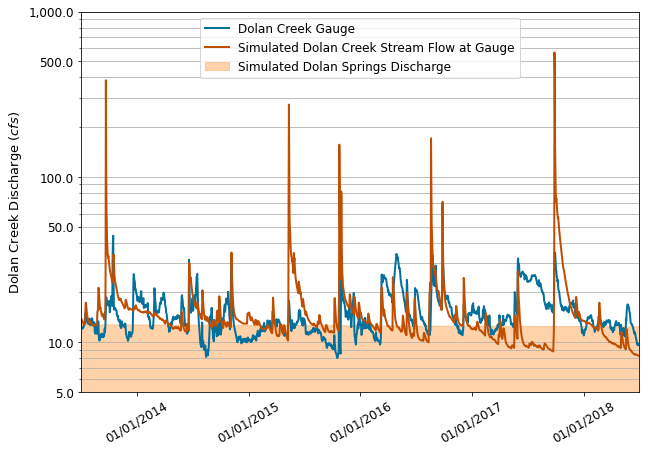

In [103]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Dcg, = ax11.plot( DCGauge.index, DCGauge[GAUGE_HDR], color='xkcd:ocean blue', linewidth=2,
                  label="Dolan Creek Gauge" )
Rc5, = ax11.plot( H_RR5.index, H_RR5["ovol_cfs"], color='xkcd:burnt orange', linewidth=2,
                  label="Simulated Dolan Creek Stream Flow at Gauge" )
sfF = ax11.fill( DTTimeList, ValsList, color='xkcd:pale orange', alpha=0.5, 
                 label="Simulated Dolan Springs Discharge")
#ax11.legend( (Dcg, Rc5 ), 
#             ("Dolan Creek Gauge", "Simulated Reach 5 outflow" ),
#             loc='upper center', fontsize=12)
ax11.legend(loc='upper center', fontsize=12)
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 1000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Dolan Creek Discharge ($cfs$)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

In [104]:
DRN_DF = DRN_DF.loc[CStart_DT:CEnd_DT].copy()

#### RCH

In [105]:
RCHO_Path = os.path.join(MF6_Dir, 'recharge_obs.bsv')

In [106]:
RCHObs_DF = pd.read_csv(RCHO_Path)

In [107]:
chdrs = list( RCHObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( RCHObs_DF[tHdr], dtype=np.float64 )
# end for
RCH_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [108]:
display( HTML( RCH_DF.describe().to_html()))

,time,RECHARGE
count,2069.000000,2069.00000
mean,1035.000000,439.06414
std,597.413174,1570.70203
min,1.000000,0.00000
25%,518.000000,0.00000
50%,1035.000000,0.00000
75%,1552.000000,20.52900
max,2069.000000,18740.00000


In [109]:
# Export as Spreadsheet
RCHOut_Path = os.path.join(MF6_Out_Dir, "%s-RCH_Budget.xlsx" % OUT_ROOT )
RCH_DF.to_excel(RCHOut_Path)

#### GHB

In [110]:
GHBO_Path = os.path.join( MF6_Dir, r'ghb_obs.bsv' )

In [111]:
GHBObs_DF = pd.read_csv(GHBO_Path)

In [112]:
chdrs = list( GHBObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( GHBObs_DF[tHdr], dtype=np.float64 )
# end for
GHB_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [113]:
display( HTML( GHB_DF.describe().to_html() ) )

,time,EAST,NORTH,WEST,PATH
count,2069.000000,2069.000000,2069.000000,2069.000000,2069.000000
mean,1035.000000,5468.514403,2319.400483,-10648.768777,25561.811986
std,597.413174,33.301954,13.589040,1980.852972,73.216181
min,1.000000,5421.800000,2303.100000,-15345.000000,25466.000000
25%,518.000000,5438.000000,2309.000000,-12103.000000,25492.000000
50%,1035.000000,5464.900000,2317.300000,-10291.000000,25552.000000
75%,1552.000000,5496.700000,2327.900000,-8931.300000,25626.000000
max,2069.000000,5572.900000,2414.000000,-7911.400000,25699.000000


In [114]:
# Export as Spreadsheet
GHBOut_Path = os.path.join(MF6_Out_Dir, "%s-GHB_Budget.xlsx" % OUT_ROOT )
GHB_DF.to_excel(GHBOut_Path)

In [115]:
GHB_DF = GHB_DF.loc[CStart_DT:CEnd_DT].copy()

#### CHD

In [116]:
CHDO_Path = os.path.join( MF6_Dir, r'chd_obs.bsv' )

In [117]:
CHDObs_DF = pd.read_csv(CHDO_Path)

In [118]:
chdrs = list( CHDObs_DF.columns )
DataDict = dict()
for tHdr in chdrs:
    DataDict[tHdr] = np.array( CHDObs_DF[tHdr], dtype=np.float64 )
# end for
CHD_DF = pd.DataFrame( index=MFDTIndex, data=DataDict )

In [119]:
display( HTML( CHD_DF.describe().to_html() ) )

,time,SOUTHOUT
count,2069.000000,2069.000000
mean,1035.000000,-109.864543
std,597.413174,24.702792
min,1.000000,-202.440000
25%,518.000000,-122.130000
50%,1035.000000,-101.220000
75%,1552.000000,-90.611000
max,2069.000000,-84.754000


In [120]:
# Export as Spreadsheet
CHDOut_Path = os.path.join(MF6_Out_Dir, "%s-CHD_Budget.xlsx" % OUT_ROOT )
CHD_DF.to_excel(CHDOut_Path)

### Make Coupled Discharge Plots

The main purpose in making and looking at the coupled discharge tracking information is to find where whater might be cycling back and forth between HSPF and MODFLOW 6. In this example model, the primary location for cycling will be the stream segments. The cycling is likely to happen under the scenario that HSPF sends water to MODFLOW 6 UZF and the water table is too high in the stream segment so that this water is either sent back to HSPF as rejected infiltration or goes to groundwater discharge to ground surface in the stream valley.

The tracking arrays are numpy rec.arrays so need to use memory views to extract and further process this information into DataFrames

In [121]:
nuzf = IndexDict['nuzf']
numMonths = len( MFMonIndex )
NCPL, nuzf, numMonths

(12347, 11536, 68)

In [122]:
vUZF = TRACK_UZF_IN.view(dtype=np.float64).reshape( nuzf, numMonths )
vGSURF = TRACK_DIS_OUT.view(dtype=np.float64).reshape( NCPL, numMonths )
vREJINF = TRACK_REJI_OUT.view(dtype=np.float64).reshape( NCPL, numMonths )

In [123]:
vUZF.shape

(11536, 68)

Create DataFrames from these rec.arrays

In [124]:
ncplList = [ x for x in range(1, NCPL+1, 1)]
uzfList = [ x for x in range(1, nuzf+1, 1)]

In [125]:
monTSList = list( MFMonIndex.to_pydatetime() )
monHdrs = [ x.strftime( "%Y%m" ) for x in monTSList ]

In [126]:
monHdrs[:5]

['201301', '201302', '201303', '201304', '201305']

In [127]:
DataDUZF = { 'nuzf' : uzfList }
DataDDis = { 'CellID' : ncplList }
DataDRI = { 'CellID' : ncplList }
iCnt = 0
for tHdr in monHdrs:
    DataDUZF[tHdr] = vUZF[:,iCnt].copy()
    DataDDis[tHdr] = vGSURF[:,iCnt].copy()
    DataDRI[tHdr] = vREJINF[:,iCnt].copy()
    iCnt += 1
# end for

In [128]:
toUZFDF = pd.DataFrame( data=DataDUZF )
toH2DisDF = pd.DataFrame( data=DataDDis )
toH2RejIDF = pd.DataFrame( data=DataDRI )

Add some summary columns to the DataFrames

In [129]:
toUZFDF["Sum"] = toUZFDF[monHdrs].sum( axis=1 )
toUZFDF["Mean"] = toUZFDF[monHdrs].mean( axis=1 )
toUZFDF["Min"] = toUZFDF[monHdrs].min( axis=1 )
toUZFDF["Max"] = toUZFDF[monHdrs].max( axis=1 )
toUZFDF["StDev"] = toUZFDF[monHdrs].std( axis=1 )
toH2DisDF["Sum"] = toH2DisDF[monHdrs].sum( axis=1 )
toH2DisDF["Mean"] = toH2DisDF[monHdrs].mean( axis=1 )
toH2DisDF["Min"] = toH2DisDF[monHdrs].min( axis=1 )
toH2DisDF["Max"] = toH2DisDF[monHdrs].max( axis=1 )
toH2DisDF["StDev"] = toH2DisDF[monHdrs].std( axis=1 )
toH2RejIDF["Sum"] = toH2RejIDF[monHdrs].sum( axis=1 )
toH2RejIDF["Mean"] = toH2RejIDF[monHdrs].mean( axis=1 )
toH2RejIDF["Min"] = toH2RejIDF[monHdrs].min( axis=1 )
toH2RejIDF["Max"] = toH2RejIDF[monHdrs].max( axis=1 )
toH2RejIDF["StDev"] = toH2RejIDF[monHdrs].std( axis=1 )

Extract some values

In [130]:
ExCols = ["Sum", "Mean", "Min", "Max", "StDev"]
outUZFDF = toUZFDF[ExCols].copy()
UZFOut_Path = os.path.join(MF6_Out_Dir, "%s-HSPFUZF_Budget.xlsx" % OUT_ROOT )
outUZFDF.to_excel(UZFOut_Path)

Add the geometries so that can make a GeoPandas GeoDataFrame

In [131]:
display( HTML( gpd_UzfGrid.head().to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,geometry
0,1,1,-1,D,0,1,"POLYGON ((331000.000 3342000.000, 332000.000 3342000.000, 332000.000 3341000.000, 331000.000 3341000.000, 331000.000 3342000.000))"
1,2,1,-1,D,0,1,"POLYGON ((332000.000 3342000.000, 333000.000 3342000.000, 333000.000 3341000.000, 332000.000 3341000.000, 332000.000 3342000.000))"
2,3,1,-1,D,0,1,"POLYGON ((333000.000 3342000.000, 334000.000 3342000.000, 334000.000 3341000.000, 333000.000 3341000.000, 333000.000 3342000.000))"
3,4,1,-1,D,0,1,"POLYGON ((330000.000 3341000.000, 331000.000 3341000.000, 331000.000 3340000.000, 330000.000 3340000.000, 330000.000 3341000.000))"
4,5,1,1,D,0,1,"POLYGON ((331000.000 3341000.000, 332000.000 3341000.000, 332000.000 3340000.000, 331000.000 3340000.000, 331000.000 3341000.000))"


In [132]:
display( HTML( gpd_UzfGrid.tail().to_html() ) )

,CellID,TopAct,iuzno,HSoil,FtTerrOut,HRU,geometry
12342,12343,3,-1,D,0,8,"POLYGON ((311500.000 3307875.000, 311625.000 3307875.000, 311625.000 3307750.000, 311500.000 3307750.000, 311500.000 3307875.000))"
12343,12344,3,-1,D,0,8,"POLYGON ((311750.000 3308000.000, 311875.000 3308000.000, 311875.000 3307875.000, 311750.000 3307875.000, 311750.000 3308000.000))"
12344,12345,-1,-1,D,0,8,"POLYGON ((311500.000 3307750.000, 311750.000 3307750.000, 311750.000 3307500.000, 311500.000 3307500.000, 311500.000 3307750.000))"
12345,12346,3,-1,D,0,8,"POLYGON ((312625.000 3308000.000, 312750.000 3308000.000, 312750.000 3307875.000, 312625.000 3307875.000, 312625.000 3308000.000))"
12346,12347,3,-1,D,0,8,"POLYGON ((312750.000 3308000.000, 312875.000 3308000.000, 312875.000 3307875.000, 312750.000 3307875.000, 312750.000 3308000.000))"


In [133]:
# get just get the geometry field as a list for the NCPL dimension DataFrames
GeomCellID = gpd_UzfGrid['geometry'].tolist()

In [134]:
Geomiuzno = list()
for iI in uzfList:
    cPoly = gpd_UzfGrid['geometry'][gpd_UzfGrid['iuzno'] == iI ].values
    Geomiuzno.append( cPoly[0] )
# end for

In [135]:
len( Geomiuzno )

11536

In [136]:
gpd_tUZF = gpd.GeoDataFrame( toUZFDF, geometry=Geomiuzno ) 
gpd_tSurfDis = gpd.GeoDataFrame( toH2DisDF, geometry=GeomCellID )
gpd_tRejI = gpd.GeoDataFrame( toH2RejIDF, geometry=GeomCellID )

In [137]:
display( HTML( gpd_tUZF.describe().to_html() ) )

,nuzf,201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312,201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,Sum,Mean,Min,Max,StDev
count,11536.000000,11536.000000,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,11536.000000,11536.000000,1.153600e+04,1.153600e+04,11536.000000,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,11536.000000,11536.000000,1.153600e+04,1.153600e+04,11536.000000,11536.000000,1.153600e+04,11536.000000,1.153600e+04,11536.000000,11536.000000,1.153600e+04,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,11536.000000,1.153600e+04,1.153600e+04,11536.000000,11536.000000,11536.000000,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,1.153600e+04,1.153600e+04,11536.000000,1.153600e+04,1.153600e+04,11536.000000,11536.000000,11536.000000,11536.000000,11536.000000
mean,5768.500000,0.005115,0.009144,1.045854e-02,1.014370e-02,1.059238e-02,1.025368e-02,1.053945e-02,0.010446,0.010433,0.011194,1.076072e-02,1.102623e-02,0.010941,9.820603e-03,0.010697,1.006554e-02,1.016095e-02,0.009892,1.047338e-02,1.034958e-02,9.817084e-03,1.002735e-02,0.009781,1.002688e-02,9.983760e-03,8.935880e-03,9.824770e-03,9.451249e-03,0.010482,0.010460,1.071738e-02,1.052998e-02,9.872611e-03,0.010219,0.010326,0.010609,1.038825e-02,9.502676e-03,0.010301,0.010102,1.039782e-02,0.009916,1.010331e-02,0.010212,0.010147,1.063713e-02,1.005850e-02,0.010353,1.013431e-02,9.015843e-03,9.810609e-03,9.383029e-03,0.009590,0.009435,9.575663e-03,9.566009e-03,0.009400,0.010784,0.010300,1.055797e-02,0.010484,9.231611e-03,9.962921e-03,9.366075e-03,9.532556e-03,0.009075,9.274406e-03,9.241405e-03,0.679409,0.009991,0.004987,0.011334,0.001110
std,3330.300687,0.018577,0.032622,3.678475e-02,3.560052e-02,3.689739e-02,3.571013e-02,3.682454e-02,0.036703,0.035785,0.037509,3.622736e-02,3.731273e-02,0.037203,3.352675e-02,0.036910,3.541462e-02,3.637572e-02,0.035196,3.666317e-02,3.652795e-02,3.517900e-02,3.626142e-02,0.035145,3.627344e-02,3.624410e-02,3.268097e-02,3.613326e-02,3.493808e-02,0.036525,0.035827,3.694801e-02,3.674552e-02,3.523653e-02,0.036345,0.035676,0.036799,3.658290e-02,3.402312e-02,0.036449,0.035434,3.659540e-02,0.035254,3.632727e-02,0.036295,0.035370,3.684326e-02,3.540306e-02,0.036523,3.635688e-02,3.273527e-02,3.612377e-02,3.488863e-02,0.035968,0.034928,3.601524e-02,3.602760e-02,0.034850,0.036996,0.035724,3.680674e-02,0.036736,3.292184e-02,3.621611e-02,3.485608e-02,3.593989e-02,0.034716,3.583605e-02,3.583417e-02,2.412938,0.035484,0.018454,0.037507,0.003362
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2884.750000,0.

In [138]:
display( HTML( gpd_tSurfDis.describe().to_html() ) )

,CellID,201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312,201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,Sum,Mean,Min,Max,StDev
count,12347.000000,1.234700e+04,1.234700e+04,1.234700e+04,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,1.234700e+04,12347.000000,12347.000000,1.234700e+04,12347.000000
mean,6174.000000,9.076725e+02,5.228316e+02,4.800154e+02,414.445365,397.895733,365.238023,362.315681,350.471867,330.869034,336.992279,321.447999,327.670979,323.305385,288.456143,315.534182,301.247467,307.129342,293.818691,301.712826,299.424267,287.191552,294.210635,282.834070,290.506525,288.631717,259.064215,284.919942,274.096108,282.223511,273.950780,282.770404,281.447657,270.617484,277.665312,268.579378,277.149635,276.203738,257.029419,273.662021,264.331330,272.482258,262.595182,270.389048,268.973336,259.923864,269.031324,259.674383,267.581481,266.498179,239.477195,263.711992,253.730433,260.609044,251.657699,259.020042,258.022906,248.662438,257.757507,249.835851,257.895424,257.461920,231.832955,255.638062,245.958170,252.758627,243.357828,250.109505,249.071148,2.027930e+04,298.224972,216.965349,9.326557e+02,105.537150
std,3564.416221,3.527601e+04,1.723209e+04,1.388660e+04,10915.593447,9877.697858,8762.621840,8540.119867,8194.050672,7708.676106,7807.782340,7437.068025,7587.715361,7508.222535,6724.994960,7392.477343,7106.033964,7298.870605,7028.727750,7236.291919,7209.966036,6952.183385,7160.097941,6909.509818,7120.312261,7102.059079,6399.307696,7068.589173,6825.966691,7042.704870,6813.284541,7031.694884,7018.716220,6778.395251,6990.256652,6759.094287,6977.055949,6966.980521,6506.279851,6945.742448,6714.880635,6931.359516,6699.236792,6913.458442,6903.063505,6675.320270,6895.580865,6665.768302,6880.623974,6870.954108,6197.000050,6850.589153,6619.915594,6830.110303,6605.128984,6816.870750,6809.252523,6581.913252,6801.938972,6580.335592,6795.302372,6789.574841,6126.535980,6775.245925,6547.204022,6756.999987,6530.798797,6740.368756,6733.463515,4.987248e+05,7334.188585,6108.041342,3.528431e+04,4527.268080
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000
25%,3087.500000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [139]:
display( HTML( gpd_tRejI.describe().to_html() ) )

,CellID,201301,201302,201303,201304,201305,201306,201307,201308,201309,201310,201311,201312,201401,201402,201403,201404,201405,201406,201407,201408,201409,201410,201411,201412,201501,201502,201503,201504,201505,201506,201507,201508,201509,201510,201511,201512,201601,201602,201603,201604,201605,201606,201607,201608,201609,201610,201611,201612,201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,Sum,Mean,Min,Max,StDev
count,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.00000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000
mean,6174.000000,9.713741,15.801203,18.026664,17.289258,17.811700,17.064475,17.36517,17.046775,16.588370,17.317656,16.561096,16.900865,16.681038,14.868613,16.195142,15.338292,15.563460,15.014071,15.612335,15.458215,14.773718,15.155190,14.720914,15.116698,15.060363,13.504889,14.857693,14.307016,15.069531,14.852395,15.245318,15.034261,14.318089,14.722764,14.517390,14.967694,14.859070,13.743467,14.772553,14.329459,14.740322,14.162704,14.598127,14.542190,14.206600,14.890505,14.222379,14.724744,14.560462,13.038529,14.276913,13.708742,14.033000,13.782638,14.084286,14.096040,13.597825,14.468154,13.853701,14.256453,14.179782,12.682809,13.915645,13.289059,13.667829,13.129119,13.493892,13.485716,1007.834776,14.821100,7.848954,19.207329,2.192494
std,3564.416221,95.199240,125.744264,141.706140,136.712873,141.496992,136.407600,139.88781,138.601459,134.901688,140.749208,135.406018,139.042407,138.122699,123.911767,136.003706,130.146382,133.330216,128.868842,133.724622,133.068016,128.028783,131.892278,127.900725,131.812856,131.627454,118.530846,130.903778,126.451442,131.721262,128.889379,132.711447,131.763929,126.512329,130.411684,127.538031,131.624382,131.130533,122.017464,130.793399,126.784266,130.753466,126.094614,130.187997,129.891618,126.322416,131.635518,126.487349,130.858867,130.161634,117.124726,129.065980,124.517821,128.172502,124.882200,128.416776,128.488479,124.041989,130.026287,125.204113,129.113250,128.810977,115.794064,127.694948,122.964265,126.869513,122.480684,126.348185,126.323517,8737.930777,128.498982,89.466272,145.765766,15.712573
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3087.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

In [140]:
gpd_tUZF.crs = ProjCRS
gpd_tSurfDis.crs = ProjCRS
gpd_tRejI.crs = ProjCRS

In [141]:
OutFiler = os.path.normpath( os.path.join( MF6_Out_Dir, "%s_UZF_from_H2.shp" % OUT_ROOT ) )
gpd_tUZF.to_file( OutFiler )
OutFiler = os.path.normpath( os.path.join( MF6_Out_Dir, "%s_MF6_SurfDis.shp" % OUT_ROOT ) )
gpd_tSurfDis.to_file( OutFiler )
OutFiler = os.path.normpath( os.path.join( MF6_Out_Dir, "%s_MF6_RejInf.shp" % OUT_ROOT ) )
gpd_tRejI.to_file( OutFiler )

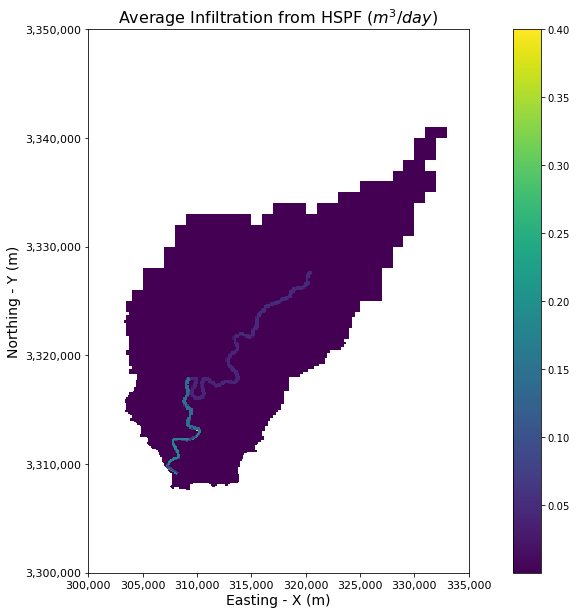

In [142]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_tUZF.plot( ax=ax11, column="Mean", cmap='viridis', vmin=0.000002, vmax=0.4, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Average Infiltration from HSPF ($m^{3}/day$)", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

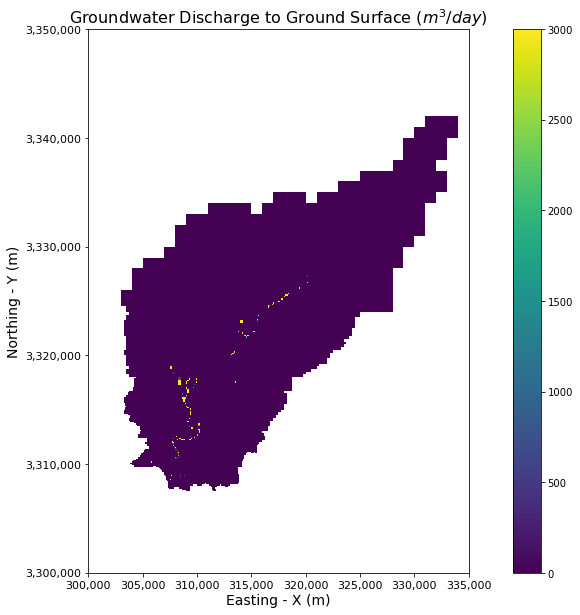

In [143]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_tSurfDis.plot( ax=ax11, column="Mean", cmap='viridis', vmin=0.0, vmax=3000.0, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Groundwater Discharge to Ground Surface ($m^{3}/day$)", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

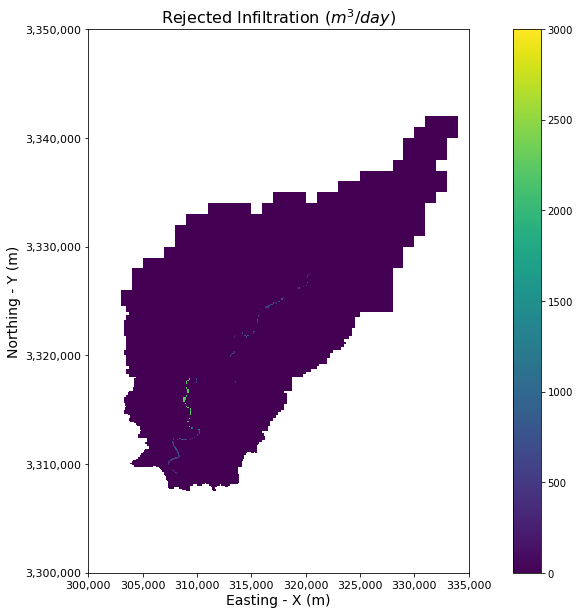

In [144]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_tRejI.plot( ax=ax11, column="Mean", cmap='viridis', vmin=0.0, vmax=3000.0, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Rejected Infiltration ($m^{3}/day$)", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

### Make Head Plots

For head values, a value below the bottom of the cell denotes a dry cell. A default value out of the range of possible values denotes inactive cells

- -1E+30: dry cell
- 1E+30: inactive cells

In [145]:
# Read the binary head file and plot the results
# We can use the existing Flopy HeadFile class because
# the format of the headfile for MODFLOW 6 is the same
# as for previous MODFLOW verions
headfile = '{}.hds'.format(MF6_Root)
fname = os.path.join(MF6_Dir, headfile)
hds = flopy.utils.binaryfile.HeadFile(fname)

In [146]:
AllOutTimes = hds.get_times()
NumOut = len( AllOutTimes )
NumOut

68

Loop through and get a shapefile for all of our heads outputs

In [147]:
HMax = 680.0
HMin = 400.0

In [148]:
for tT in AllOutTimes:
    h = hds.get_data(totim=tT)
    curDT = StartDT + dt.timedelta(days=tT)
    reH = np.reshape( h, ( NLAY, NCPL ) )
    # determine water table elevation and layer
    WTEl = reH[0,:].copy()
    WTLay = np.where( ( (reH[0,:] > 1E+29) | (reH[0,:] < -1E+29) ), -1, 1 )
    WTLay = np.where( ( ( (reH[0,:] > 1E+29) | (reH[0,:] < -1E+29) ) & 
                        ( (reH[1,:] < 1E+29) | (reH[1,:] > -1E+29) ) ), 2, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[1,:], WTEl )
    WTLay = np.where( ( ( (reH[1,:] > 1E+29) | (reH[1,:] < -1E+29) ) & 
                        ( (reH[2,:] < 1E+29) | (reH[2,:] > -1E+29) ) ), 3, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[2,:], WTEl )
    WTLay = np.where( ( ( (reH[2,:] > 1E+29) | (reH[2,:] < -1E+29) ) & 
                        ( (reH[3,:] < 1E+29) | (reH[3,:] > -1E+29) ) ), 4, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[3,:], WTEl )
    WTLay = np.where( ( ( (reH[3,:] > 1E+29) | (reH[3,:] < -1E+29) ) & 
                        ( (reH[4,:] < 1E+29) | (reH[4,:] > -1E+29) ) ), 5, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[4,:], WTEl )
    WTLay = np.where( ( ( (reH[4,:] > 1E+29) | (reH[4,:] < -1E+29) ) & 
                        ( (reH[5,:] < 1E+29) | (reH[5,:] > -1E+29) ) ), 6, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[5,:], WTEl )
    WTLay = np.where( ( ( (reH[5,:] > 1E+29) | (reH[5,:] < -1E+29) ) & 
                        ( (reH[6,:] < 1E+29) | (reH[6,:] > -1E+29) ) ), 7, WTLay )
    WTEl = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), reH[6,:], WTEl )
    # make the levels and mask in case want to do plots
    CLevels =[ HMin + (x*10.0) for x in range( int((HMax - HMin)/10.0) + 1 ) ]
    WTabMask = np.where( ( ( WTEl > 1E+29 ) | ( WTEl < -1E+29 ) ), True, False )
    # replace our our out of range values with NaNs
    reH = np.where( (( reH > 1E+29 ) | ( reH < -1E+29 )), np.nan, reH )
    WTEl = np.where( (( WTEl > 1E+29 ) | ( WTEl < -1E+29 )), np.nan, WTEl )
    # make our dataframe
    DataDict = { "CellID" : np.array( [x for x in range(1, NCPL+1, 1) ], dtype=np.int32 ),
                 "WTLayer" : WTLay,
                 "WTElev" : WTEl,
                 "HdL1" : reH[0,:],
                 "HdL2" : reH[1,:],
                 "HdL3" : reH[2,:],
                 "HdL4" : reH[3,:],
                 "HdL5" : reH[4,:],
                 "HdL6" : reH[5,:],
                 "HdL7" : reH[6,:], }
    cpDF = pd.DataFrame( data=DataDict )
    # make our GeoDataFrame
    gpd_Heads = gpd.GeoDataFrame( cpDF, geometry=PointList2D )
    gpd_Heads.crs = gpd_MGrid.crs
    # calculate the depth to water
    gpd_Heads["DepWater"] = gpd_MSurf["SurfEl"] - gpd_Heads["WTElev"]
    # output to a shapefile
    outFile = os.path.normpath( os.path.join( MF6_Out_Dir, "%s_HdPoints_TR-%s.shp" % 
                                             ( OUT_ROOT, curDT.strftime("%Y%m%d") ) ) )
    gpd_Heads.to_file( outFile )
# end of heads out file

In [149]:
display( HTML( gpd_Heads.describe().to_html() ) )

,CellID,WTLayer,WTElev,HdL1,HdL2,HdL3,HdL4,HdL5,HdL6,HdL7,DepWater
count,12347.000000,12347.000000,12293.000000,182.000000,2490.000000,7054.000000,10124.000000,11690.000000,12293.000000,12293.000000,12293.000000
mean,6174.000000,3.449907,481.338100,566.117362,544.418864,510.327532,493.350398,484.581458,480.929288,480.951341,55.762948
std,3564.416221,1.144146,51.861551,19.685144,25.301186,45.105217,48.312308,50.231727,51.733715,51.744513,37.122014
min,1.000000,1.000000,391.000000,532.322220,462.542454,395.025830,392.889772,391.159127,391.000000,392.662389,0.224383
25%,3087.500000,3.000000,439.846957,546.794131,528.285048,472.089025,452.227524,443.439357,439.803583,439.926216,21.913089
50%,6174.000000,3.000000,472.759619,568.040370,544.737436,521.119078,488.667987,475.739139,472.485492,473.359638,54.000421
75%,9260.500000,4.000000,529.978274,581.780099,563.538067,546.720670,536.150742,530.559249,527.919572,527.783931,86.820469
max,12347.000000,7.000000,598.328303,596.818953,598.328303,597.158450,596.869161,596.875830,596.876093,596.867947,154.483454


Now do some plots of the last output time

Get the locations where the water table is above the ground surface

In [150]:
FloodedLocs = gpd_Heads[gpd_Heads["DepWater"] <= 0.1 ].copy()
len(FloodedLocs)

0

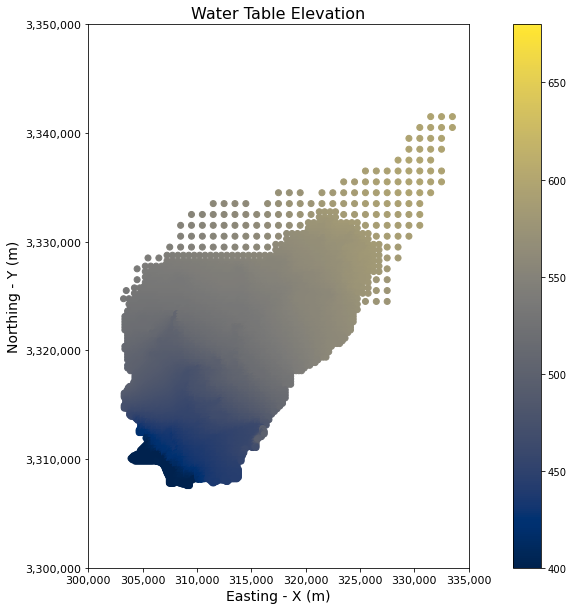

In [151]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_Heads.plot( ax=ax11, column="WTElev", cmap='cividis', vmin=HMin, vmax=HMax, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Water Table Elevation", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

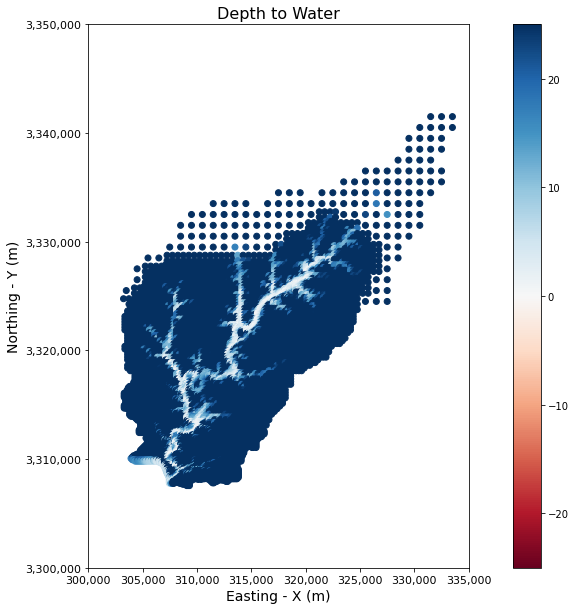

In [152]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_Heads.plot( ax=ax11, column="DepWater", cmap='RdBu', vmin=-25, vmax=25, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Depth to Water", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

C:\Users\nmart\.conda\envs\pyhs2mf6\lib\site-packages\geopandas\plotting.py:484: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


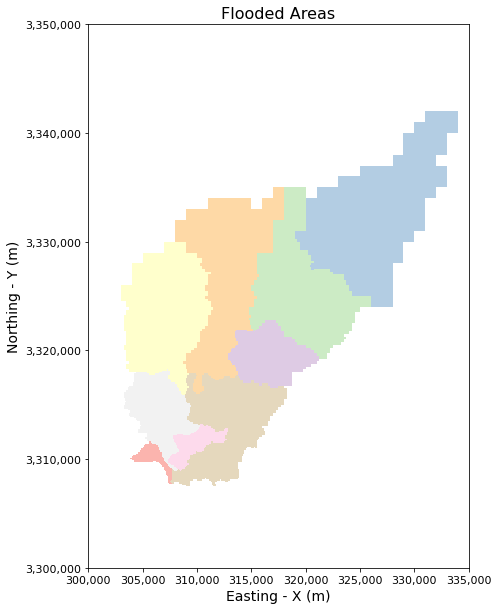

In [153]:
Fig1 = plt.figure()
Fig1.set_size_inches(16.0, 10.0)
ax11 = Fig1.add_subplot(111)
gpd_MGrid.plot( ax=ax11, column='HRU', cmap='Pastel1')
FloodedLocs.plot( ax=ax11, column="DepWater", cmap='viridis', vmin=-20, vmax=0, legend=True)
ax11.set_xlim( ( 300000, 335000 ) )
ax11.set_ylim( ( 3300000, 3350000 ) )
ax11.set_title( "Flooded Areas", fontsize=16 )
ax11.set_xlabel('Easting - X (m)', fontsize=14 )
ax11.set_ylabel('Northing - Y (m)', fontsize=14)
ax11.tick_params(axis='both', which='major', labelsize=11)
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
ax11.xaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )

## Compare MODFLOW 6 and HSPF Budget Items

The comparison points are the information sent back and forth between the two programs. HSPF outputs are generally in acre-feet per day while MODFLOW 6 outputs are generally in cubic meters per day.

- HSPF sends all information to MODFLOW 6 to the UZF package as specified infiltration rates
    - A 1D array is sent that has NUZFCELLS as the dimension
    - The specified weights for each UZF cell in the input mapping dictionaries provides the transfer from the lumped HSPF PERLND and RCHRES objects to the MODFLOW 6 UZF grid
        - Deep infiltration to inactivate groundwater is sent to UZF cells in HRUs
        - Stream flow losses to groundwater through the specified RCHRES exit are sent to UZF cells in stream segments
- MODFLOW 6 sends all groundwater discharge to the ground surface to HSPF for HSPF to route through the surface water balance
    - A 1D array is sent that NCPL as the dimension. NCPL is the number of cells in each layer of the model
    - The mapping dictionaries provide the assignment of Cell ID (1 to NCPL) to HSPF RCHRES and PERLND target Ids.
        - The sum of groundwater discharge for each target Id is incorporated into the water budget for that location
        - PERLND or HRUs have the discharge volume converted to inches and this is added first to the lower soil zone. If the nominal capacity of the lower soil zone is exceeded the remaining discharge is then added to the upper soil zone. If the nominal capacity of the upper soil zone is exceeded, the remaining discharge is routed directly to the outflow stream segment for the HRU as runoff.
        - RCHRES have the discharge volume added directly to the current stream segement water volume. This water is then routed downstream in the subsequent time step.

HSPF budget items are converted to cubic meters per day for comparison with the MODFLOW items.

The UZF package water balances works as follows. "Infiltration that is routed through the unsaturated zone to the water table is incorporated into the CVFD flow equation using the standard formulation. If the water table rises into the unsaturated zone then recharge is calculated as the sum of water flowing through the unsaturated zone and the volume of water stored in the
unsaturated zone submerged by the rising water table. If the water table is equal to or above land surface, then
rejected infiltration is calculated as a linear function of groundwater head using the standard formulation."

This explains why the "Recharge" output from UZF observations can be quite a bit larger than infiltration because it can included Sy water in the unsaturated zone that is there from previous times.

### Total Budgets

In [154]:
UZF_DF["Tot2_HSPF"] = (-1.0 * ( UZF_DF["Tot_Discharge"] + UZF_DF["Tot_RejInfilt"] + DRN_DF["Rch5_Spring"] ) )

In [155]:
OutSVG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_SurfDis_Check-Test.svg" ) )
OutSVG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_SurfDis_Check-Test.svg'

In [156]:
OutPNG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_SurfDis_Check-Test.png" ) )
OutPNG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_SurfDis_Check-Test.png'

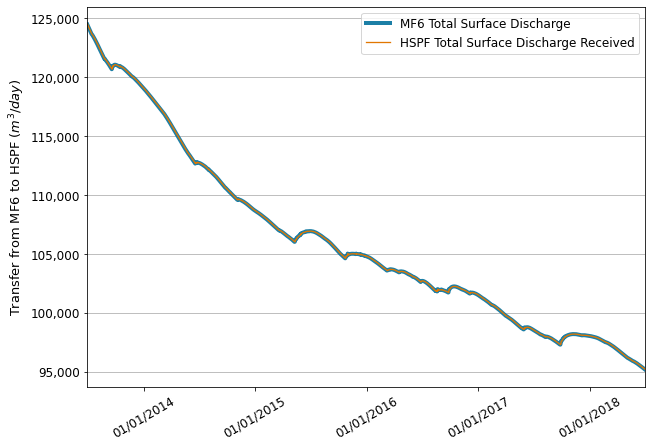

In [157]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Mf6, = ax11.plot( UZF_DF.index, UZF_DF["Tot2_HSPF"], color='xkcd:ocean blue', linewidth=4,
                  label="MF6 Total Surface Discharge", alpha=0.9 )
Hs2, = ax11.plot( cp_Tot.index, cp_Tot["Tot_UZFDis_m3d"], color='xkcd:pumpkin', linewidth=1.3,
                  label="HSPF Total Surface Discharge Received" )
ax11.legend( (Mf6, Hs2 ), 
             ("MF6 Total Surface Discharge", "HSPF Total Surface Discharge Received" ),
             loc='upper right', fontsize=12)
ax11.grid(b=True, which="both", axis='y')
#ax11.set_ylim( ( 90000.0, 130000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_ylabel('Transfer from MF6 to HSPF ($m^{3}/day$)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

In [158]:
UZF_DF["Comp_Infilt"] = UZF_DF["Tot_Infilt"]

In [159]:
OutSVG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_Infiltration_Check-Test.svg" ) )
OutSVG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_Infiltration_Check-Test.svg'

In [160]:
OutPNG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_Infiltration_Check-Test.png" ) )
OutPNG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_Infiltration_Check-Test.png'

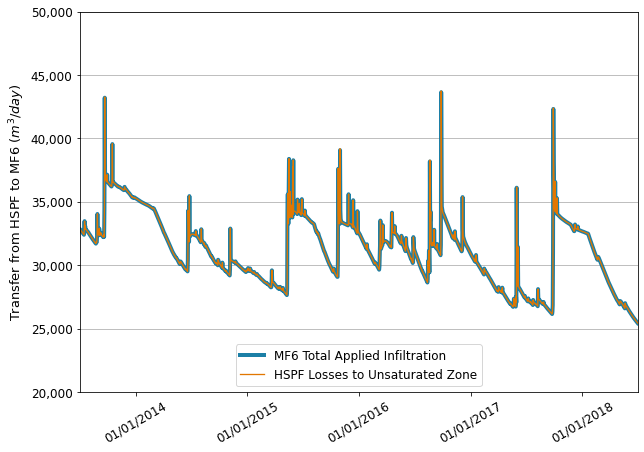

In [161]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Mf6, = ax11.plot( UZF_DF.index, UZF_DF["Comp_Infilt"], color='xkcd:ocean blue', linewidth=4,
                  label="MF6 Total Applied Infiltration", alpha=0.9)
Hs2, = ax11.plot( cp_Tot.index, cp_Tot["Tot_HtoUZF_m3d"], color='xkcd:pumpkin', linewidth=1.3,
                  label="HSPF Losses to Unsaturated Zone" )
ax11.legend( (Mf6, Hs2 ), 
             ("MF6 Total Applied Infiltration", "HSPF Losses to Unsaturated Zone" ),
             loc='lower center', fontsize=12)
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 20000.0, 50000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_ylabel('Transfer from HSPF to MF6 ($m^{3}/day$)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )

In [162]:
OutSVG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_Outside_Check-Test.svg" ) )
OutSVG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_Outside_Check-Test.svg'

In [163]:
OutPNG = os.path.normpath( os.path.join( HSPF_Out_Dir, "CP_Calib_Outside_Check-Test.png" ) )
OutPNG

'D:\\Data\\pyHS2MF6_Testing\\testCP_mHSP2\\Outputs\\CP_Calib_Outside_Check-Test.png'

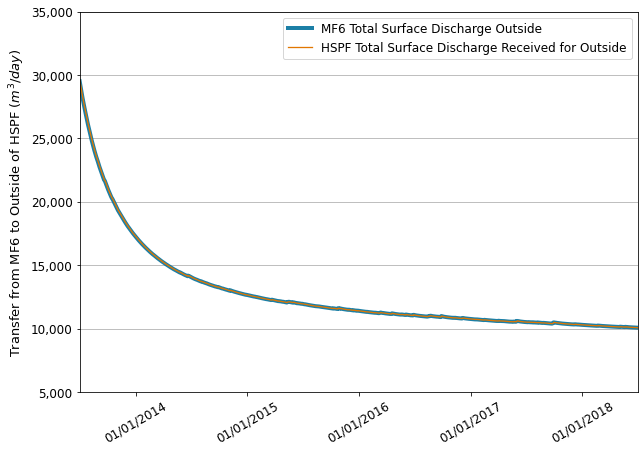

In [164]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Mf6, = ax11.plot( DRN_DF.index, (-1.0*DRN_DF["Outside"]), color='xkcd:ocean blue', linewidth=4,
                  label="MF6 Total Surface Discharge Outside", alpha=0.9 )
Hs2, = ax11.plot( cp_Tot.index, cp_Tot["Tot_Outside_m3d"], color='xkcd:pumpkin', linewidth=1.3,
                  label="HSPF Total Surface Discharge Received for Outside" )
ax11.legend( (Mf6, Hs2 ), 
             ("MF6 Total Surface Discharge Outside", "HSPF Total Surface Discharge Received for Outside" ),
             loc='upper right', fontsize=12)
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5000.0, 35000.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_ylabel('Transfer from MF6 to Outside of HSPF ($m^{3}/day$)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.0f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )